In [7]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pickle

In [8]:
import requests

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"c37483fea84b70f4ad9f777c38357ea0"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [9]:


# params = {'stars':'Coordinates,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass'}

# id = '145492'
# redshift = 2.0

# url = "http://www.tng-project.org/api/TNG50-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
# sub = get(url) # get json response of subhalo properties
# saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file
# print(saved_filename)
# print(sub)




In [10]:
saved_filename = 'cutout_145492.hdf5'

In [11]:
# import pickle
# pickle.dump(sub, open('sub.pck','wb'))

In [12]:
sub = pickle.load(open('sub.pck','rb'))

In [13]:
with h5py.File(saved_filename) as f:
    f.visit(print)
    x = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    print(len(x))

Header
PartType4
PartType4/Coordinates
PartType4/GFM_InitialMass
PartType4/GFM_Metallicity
PartType4/GFM_StellarFormationTime
308659


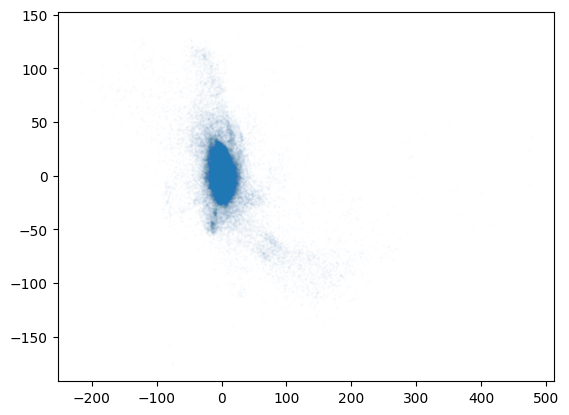

In [14]:
with h5py.File(saved_filename) as f:
    x = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    y = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
    
    plt.scatter(x,y,s=1, alpha=0.01)
    plt.show()

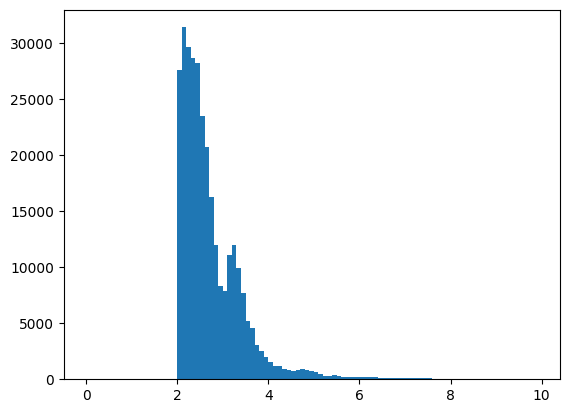

-227.67049 19.456568
238
308421


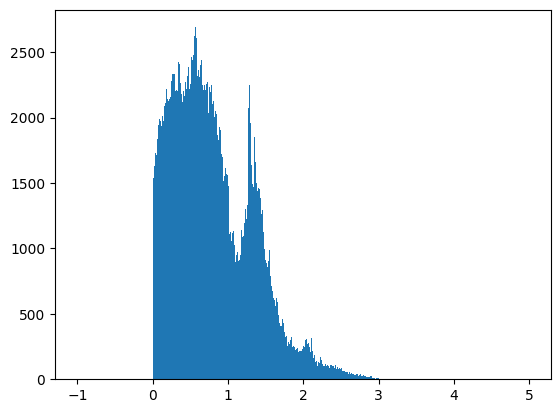

In [15]:

h = 0.7

from astropy.cosmology import Planck13 as cosmo
from unyt import Myr

with h5py.File(saved_filename) as f:

    formation_scale_factor = f['PartType4']['GFM_StellarFormationTime'][()]
    formation_redshift = 1/formation_scale_factor - 1.0
    
    plt.hist(formation_redshift, bins = np.arange(0., 10., 0.1))
    plt.show()

    print(np.min(formation_redshift), np.max(formation_redshift))
    print(np.sum(formation_redshift<0.0))
    print(np.sum(formation_redshift>2.0))

    # only select star particles that make sense
    s = formation_redshift>=2.0
    formation_redshift = formation_redshift[s]

    ages = (cosmo.age(z=2)-cosmo.age(formation_redshift)).to('Myr').value * Myr

    plt.hist(ages.to('Gyr').value, bins = np.arange(-1., 5., 0.01))
    plt.show()

In [16]:

from unyt import kpc

# get other quantities, filtering for stupid stars
with h5py.File(saved_filename) as f:
    initial_masses = f['PartType4']['GFM_InitialMass'][s] * 1E10 / h
    metallicities = f['PartType4']['GFM_Metallicity'][s]
    coordinates = f['PartType4']['Coordinates'][s,:] / h * kpc 
    coordinates = coordinates - np.mean(coordinates, axis=0)
    
    print(coordinates.shape)
    print(np.min(coordinates, axis=0), np.max(coordinates, axis=0))
    print(np.median(coordinates, axis=0), np.mean(coordinates, axis=0))

(308421, 3)
[-311.78922426 -251.21157036 -183.37820559] kpc [680.04559687 195.89368221 291.22363092] kpc
[-0.97762446  0.04131069 -0.05644802] kpc [ 4.83506983e-12 -6.93558429e-10 -1.34345073e-09] kpc


In [17]:
from synthesizer.grid import Grid
from synthesizer.filters import FilterCollection as Filters
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.kernel_functions import Kernel
from synthesizer.particle import Stars, Gas, Galaxy

Initialise stars object

In [18]:
stars = Stars(initial_masses=initial_masses,
            ages=ages,
            metallicities=metallicities,
            coordinates=coordinates, 
            )

galaxy = Galaxy(stars=stars)


Calculate SED

In [19]:
grid_dir = '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps'
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False, new_lam=np.arange(1000., 7000., 10.))

In [20]:
sed = galaxy.stars.get_particle_spectra_reprocessed(grid)

----------
SUMMARY OF SED 
Number of wavelength points: 600 
Wavelength range: [1000.00 Å,             6990.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             26.39 
log10(Bolometric luminosity/erg/s):[38.3925378  38.28409672 37.92634002 ... 38.50890246 38.52445258
 38.55958008]----------


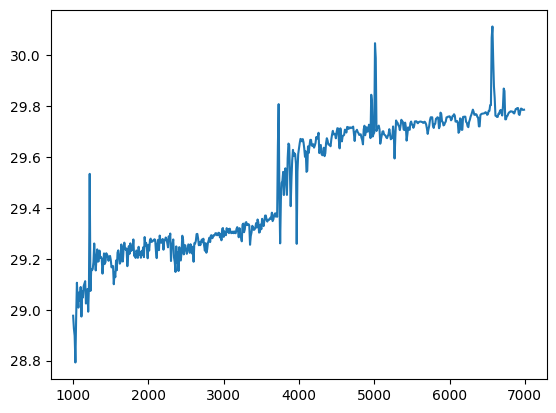

In [21]:
print(galaxy.stars.particle_spectra['incident'])

integrated_sed = sed.sum()

plt.plot(integrated_sed.lam, np.log10(integrated_sed.lnu))
plt.show()

In [22]:
from synthesizer.filters import UVJ, FilterCollection

# Get a UVJ filter set
# filters = UVJ(new_lam=grid.lam)

tophat_dict = {
    "B": {"lam_min": 1400, "lam_max": 1600},
    "G": {"lam_min": 4000, "lam_max": 6000},
    "R": {"lam_min": 6550, "lam_max": 6570},
}

tophat_dict = {
    "B": {"lam_min": 1400, "lam_max": 1600},
    "G": {"lam_min": 3000, "lam_max": 5000},
    "R": {"lam_min": 5000, "lam_max": 7000},
}

filters = FilterCollection(tophat_dict=tophat_dict, new_lam=grid.lam)

photometry = galaxy.stars.particle_spectra["reprocessed"].get_photo_luminosities(filters)


5.463590465033735e+29


/var/folders/1r/dyc06cz53k1g87b17q09by98000ft2/T/ipykernel_60790/474496448.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img.imgs['R'].arr))


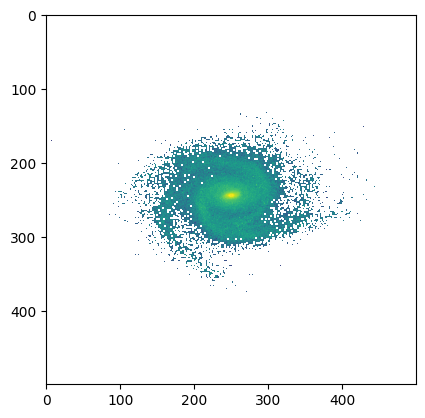

In [27]:

from unyt import kpc

fov = 100 * kpc
npix = 500
resolution = fov / npix

img = galaxy.get_images_luminosity(
    resolution=resolution,
    stellar_photometry="reprocessed",
    fov=fov,
)

print(np.sum(img.imgs['R'].arr))
plt.imshow(np.log10(img.imgs['R'].arr))
# plt.imshow(img.imgs['Ha'].arr, vmin = 0.0, vmax = 1E27)
plt.show()

# img.imgs['R'].arr /= (0.6)
# img.imgs['G'].arr /= (0.5)
# img.imgs['B'].arr /= (0.15)

img.imgs['R'].arr /= (0.5)
img.imgs['G'].arr /= (0.4)
img.imgs['B'].arr /= (0.15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


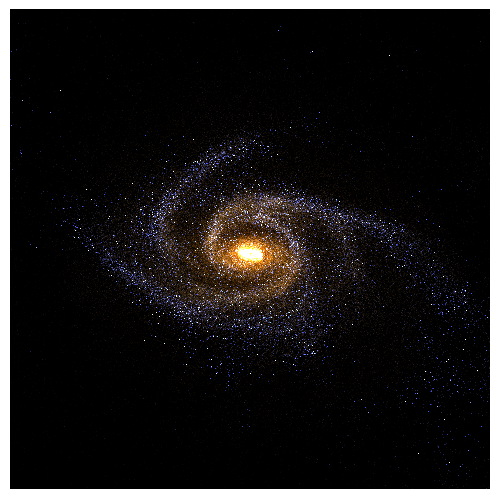

In [30]:
# Make and plot an rgb image
img.make_rgb_image(
    # rgb_filters={"R": "J", "G": "V", "B": "U"},
    rgb_filters={"R": "R", "G": "G", "B": "B"},
)
fig, ax, _ = img.plot_rgb_image(show=True, vmin=0., vmax=1E26)

fig.set_size_inches(1,1, forward=True)
ax.axis('off')
fig.savefig('rgb.png', dpi=100, bbox_inches='tight', pad_inches=0)